In [ ]:
from typing import TypedDict, Dict, List, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain_community.llms import Ollama

In [26]:
# Define custom state
class EmailState(TypedDict):
    email: Dict[str, Any]  
    email_category: Optional[str]
    spam_reason: Optional[str]
    is_spam: Optional[bool]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

In [ ]:
# Define nodes
model = Ollama(model="qwen2.5:14b")

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM (zero-shot classification)
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response
    response_text = response.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response}
    ]
    
    # Return state updates
    return {
        "email_draft": response,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

In [28]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [29]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

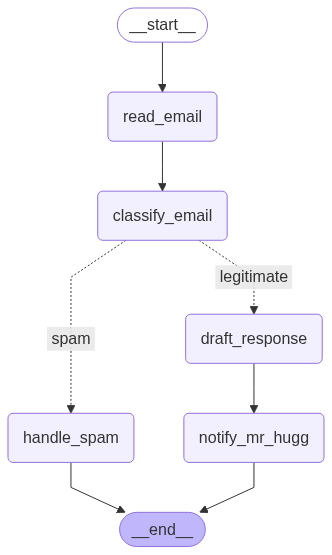

In [30]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [35]:
# Testing the flow

# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about tomato planting job.",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I would like to help you plant those tomato plants. When should I come at your garden?"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about tomato planting job.

Sir, you've received an email from john.smith@example.com.
Subject: Question about tomato planting job.
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about Tomato Planting Job

Dear Mr. Smith,

I trust this message finds you well.

Thank you for your interest in assisting with the tomato planting at my garden. Your colleague has spoken highly of your capabilities, which is why I appreciate your willingness to help.

Could you please provide me with a few dates and times that work best for you over the next couple of weeks? This will allow me to coordinate our schedules more effectively.

I look forward to hearing from you soon.

Best regards,

Alfred
Butler to Mr. Hugg


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com w